# Trainig a Diffusion Model from scratch

Exercise of train a Diffusion model to generate butterflys images. Based on Ch4 from book Hands-On Generative AI with Transformers and Diffusion Models

Basic Loop:

> Now that we have our data and model ready, let’s train it. For each training step, we do the following:
> 
> 1. Load a batch of images.
> 2. Add noise to the images. The amount of noise added depends on a specified number of timesteps: the more timesteps, the more noise. As mentioned, we want our model to denoise images with little noise and images with lots of noise. To achieve this, we’ll add random amounts of noise, so we’ll pick a random number of timesteps.
> 3. Feed the noisy images into the model.
> 4. Calculate the loss using MSE. MSE is a common loss function for regression tasks, including the UNet model’s noise prediction. It measures the average squared difference between predicted and true values, penalizing larger errors more. In the UNet model, MSE is calculated between predicted and actual noise, helping the model generate more realistic images by minimizing the loss. This is called the noise or epsilon objective.
> 4. Backpropagate the loss and update the model weights with the optimizer.
    


In [1]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import diffusers
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms


In [2]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

## Download and preprocess the data

In [3]:
# Download Dataset from hugging-face
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
train_dataset,val_dataset,test_dataset = torch.utils.data.random_split(dataset,(0.8,0.1,0.1)) 

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
image_size = 64

#Prepare images to load to the net

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),  #Data augmentation
        transforms.ToTensor(),              #Convert to Tensor
        transforms.Normalize([0.5],[0.5])   #Map tp -1 to 1
    ]
)

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


In [5]:
#   Create the Dataloader
dataset.set_transform(transform)
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


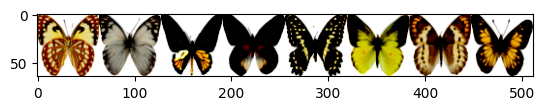

In [6]:
# Lets visualize some of the images

show_images(next(iter(train_dataloader))["images"][:8])


# Adding Noise
The noise added is controlled by a Scheduler class, which takes in a batch of images and a list of timesteps and determines how to create the noisy versions of those images

In [7]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

Lets see how the scheduler works

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79824674..1.3963585].


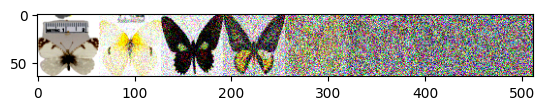

In [8]:
# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_dataloader))
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)
# [img for img in x[0:2]]

## U-Net
The U-Net is the main net of the model

It has two phases: Down-sampling and Up-sampling. Exist some interconnections between these two phases

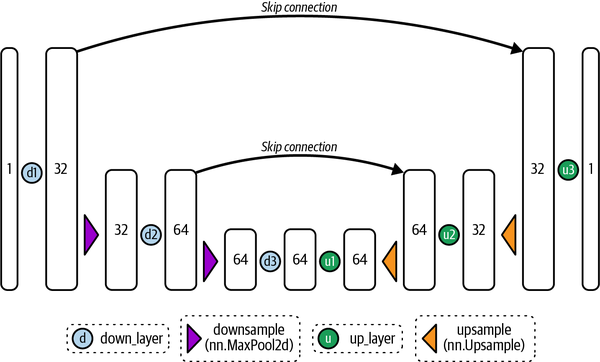

In [9]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


## Training Loops

In [10]:
from torch.nn import functional as F
n_epochs = 50
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = F.mse_loss
losses = []

In [11]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    # losses_list = []

    for nlote,x in enumerate(loader):
        x = x["images"].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [12]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x["images"].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [13]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_dataloader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_dataloader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 50 -----------------------------
Nº de lote:	 0
Loss:			 1.2075457572937012

Nº de lote:	 10
Loss:			 0.5389224290847778

Nº de lote:	 20
Loss:			 0.2868618965148926

Nº de lote:	 30
Loss:			 0.15133647620677948

Nº de lote:	 40
Loss:			 0.11500555276870728


	Accuracy/Loss Promedio
		Entrenamiento: 0.336682
		 Validación: 0.114301
Iteración: 2 / 50 -----------------------------
Nº de lote:	 0
Loss:			 0.1688961237668991

Nº de lote:	 10
Loss:			 0.07253234833478928

Nº de lote:	 20
Loss:			 0.08839654177427292

Nº de lote:	 30
Loss:			 0.09512393921613693

Nº de lote:	 40
Loss:			 0.07596409320831299


	Accuracy/Loss Promedio
		Entrenamiento: 0.093246
		 Validación: 0.069612
Iteración: 3 / 50 -----------------------------
Nº de lote:	 0
Loss:			 0.0645768940448761

Nº de lote:	 10
Loss:			 0.11886215209960938

Nº de lote:	 20
Loss:			 0.05636011064052582

Nº de lote:	 30
Loss:			 0.062176089733839035

Nº de lote:	 40
Loss:			 0.0674981027841568


	Accuracy/Loss Promedio

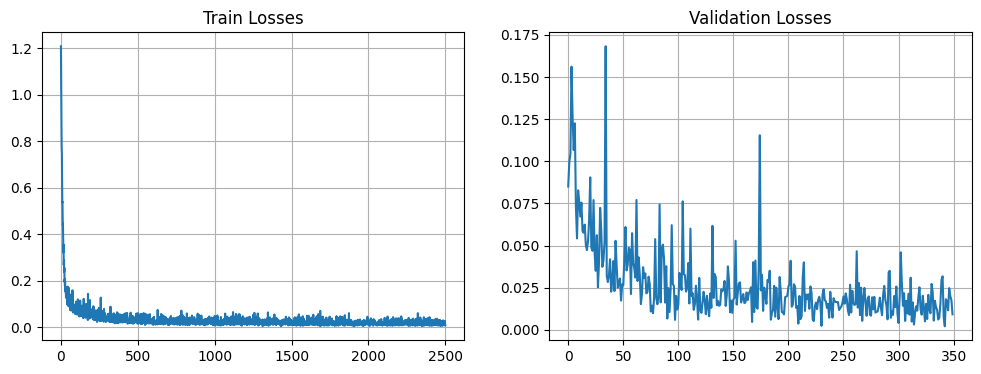

In [14]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

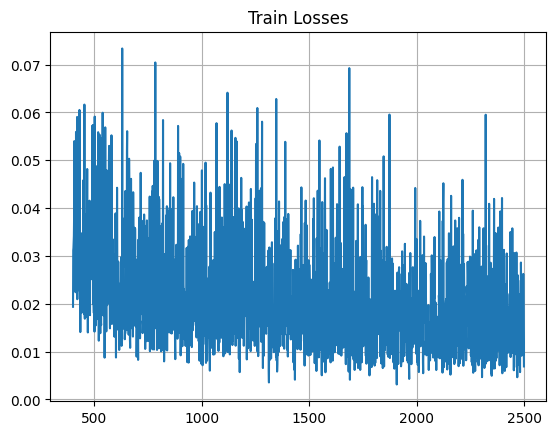

In [19]:
plt.title("Train Losses")
plt.plot(range(400,len(train_loss)),train_loss[400:]);
plt.grid()

In [15]:
# torch.save(model.state_dict(),"Second_train.pth")

In [16]:
# model = UNet2DModel(
#     in_channels=3,  # 3 channels for RGB images
#     sample_size=64,  # Specify our input size
#     # The number of channels per block affects the model size
#     block_out_channels=(64, 128, 256, 512),
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",
#         "AttnDownBlock2D",
#     ),
#     up_block_types=(
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D"
#         ),

# ).cuda()
# model.load_state_dict(torch.load("First_train.pth", weights_only=True))
# model.eval()

## Generations
After the train, lets generate some images to show how works the network

In [17]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images

  0%|          | 0/1000 [00:00<?, ?it/s]

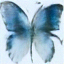

In [18]:
ims[0]